In [25]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, L_BFGS_B, NFT, ADAM, SPSA
from qiskit.aqua.operators import Z2Symmetries

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator

provider = IBMQ.load_account()

import datetime
import numpy as np
import matplotlib.pyplot as plt

ibmqfactory.load_account:WARNING:2020-12-12 20:19:24,800: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
import warnings;
warnings.filterwarnings('ignore');

In [3]:
# From Qiskit textbook - I am not brave enough to mess with this :/
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [4]:
def exact_eng(distances, exact_energies):
    for dist in distances:
        qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
        result = NumPyEigensolver(qubitOp).run()
        exact_energies.append(np.real(result.eigenvalues) + shift)
    return exact_energies

In [5]:
def get_init_state(num_spin_orbitals, num_particles):
    inits = HartreeFock(
                num_spin_orbitals,
                num_particles,
                qubit_mapping='parity'
    )
    return inits

In [6]:
def get_var_form(var_type, num_spin_orbitals, num_particles, initial_state):
    if var_type == "UCCSD":
        vf = UCCSD(
                    num_orbitals=num_spin_orbitals,
                    num_particles=num_particles,
                    initial_state=initial_state,
                    qubit_mapping='parity'
        )
    else:
        raise RuntimeError("Unsupported ansatz")
    return vf

In [7]:
def vqe_run(qubitOp, var_form, optimizers, opt, backend, shift):
    vqe = VQE(qubitOp, var_form, optimizers[opt])
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    return vqe_result

In [8]:
def vqe_run_callback(qubitOp, var_form, optimizers, opt, backend, shift):
    itrs = []
    vals = []
    stdevs = []
    
    def get_eval_result(num_eval, params, mean, std):
        itrs.append(num_eval)
        vals.append(mean)
        stdevs.append(std)
    
    vqe = VQE(qubitOp, var_form, optimizers[opt],callback=get_eval_result)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    return vqe_result, itrs, vals, stdevs

In [13]:
def vqe_test(distances, optimizers, backend, ansatz_type):
    exact_energies = []
    vqe_energies = [[] for i in range(len(optimizers))]
    vqe_result = []
    converge_itrs = [[] for i in range(len(optimizers))]
    converge_vals = [[] for i in range(len(optimizers))]
    converge_stdevs = [[] for i in range(len(optimizers))]
    
    n = 0
    ct = datetime.datetime.now()
    print("Start - ",ct)
    exact_eng(distances, exact_energies)
    for opt in optimizers:
        for dist in distances:
            qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
            initial_state = get_init_state(num_spin_orbitals, num_particles)
            var_form = get_var_form(ansatz_type, num_spin_orbitals, num_particles, initial_state)
            
            # Measure iterations only at equilibrium. Quality bush fix, lol
            if round(dist,2) == 1.6:
                vqe_result, converge_itrs[n], converge_vals[n], converge_stdevs[n] = vqe_run_callback(qubitOp, var_form, optimizers, opt, backend, shift)
                vqe_energies[n].append(vqe_result)
            else:
                vqe_energies[n].append(vqe_run(qubitOp, var_form, optimizers, opt, backend, shift))
            #vqe_energies[n].append(vqe_run(qubitOp, var_form, optimizers, opt, backend, shift))
        n += 1
        ct = datetime.datetime.now()
        print(opt,"Finish - ",ct)

    print("VQE Complete")
    return exact_energies, vqe_energies, converge_itrs, converge_vals, converge_stdevs

In [10]:
def plot_potential_well(opt_labels, distances, vqe_energies, exact_energies):
    plt.plot(distances, exact_energies, label="Exact Energy")
    for i in range(len(opt_labels)):
        plt.plot(distances, vqe_energies[i], label="VQE Energy - %s" % (opt_labels[i]))
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.title('Optimizer-Varied VQE Results')
    plt.legend()
    plt.show()

In [11]:
def plot_iterations(opt_labels, converge_itrs, converge_vals):
    for i in range(len(opt_labels)):
        plt.plot(converge_itrs[i], converge_vals[i], label="VQE Energy - %s" % (opt_labels[i]))
    plt.xlabel('Eval Count')
    plt.ylabel('Energy')
    plt.title('VQE Convergence')
    plt.legend()
    plt.show()

In [26]:
backend = BasicAer.get_backend("statevector_simulator")
ds = np.arange(0.5, 4.0, 0.1)
os = {"SLSQP":SLSQP(maxiter=3),
      "COBYLA":COBYLA(maxiter=500, disp=False, rhobeg=1.0, tol=0.2),
      "SPSA":SPSA(maxiter=100, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False)}

exact_energies, vqe_energies, converge_itrs, converge_vals, converge_stdevs = vqe_test(distances = ds, optimizers = os, backend = backend, ansatz_type = "UCCSD")

Start -  2020-12-12 20:21:39.387733
SLSQP Finish -  2020-12-12 20:25:20.955076
COBYLA Finish -  2020-12-12 20:27:33.720152
SPSA Finish -  2020-12-12 20:32:33.177952
VQE Complete


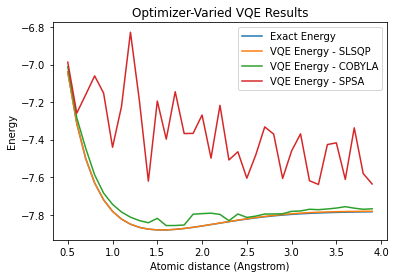

In [27]:
plot_potential_well(opt_labels = ["SLSQP","COBYLA","SPSA"], distances = ds, vqe_energies = vqe_energies, 
                    exact_energies = exact_energies)

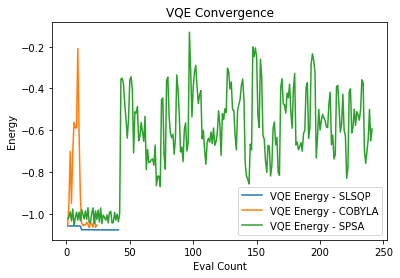

In [28]:
plot_iterations(opt_labels = ["SLSQP","COBYLA","SPSA"], converge_itrs = converge_itrs, converge_vals = converge_vals)

In [29]:
backend = BasicAer.get_backend("qasm_simulator")
ds = np.arange(0.5, 4.0, 0.1)
os = {"SLSQP":SLSQP(maxiter=5),
      "COBYLA":COBYLA(maxiter=500, disp=False, rhobeg=1.0, tol=0.2),
     "SPSA":SPSA(maxiter=100, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False)}

exact_energies, vqe_energies, converge_itrs, converge_vals, converge_stdevs = vqe_test(distances = ds, optimizers = os, backend = backend,  ansatz_type = "UCCSD")

Start -  2020-12-12 20:32:33.984266
SLSQP Finish -  2020-12-12 20:56:47.954784
COBYLA Finish -  2020-12-12 21:15:12.373943
SPSA Finish -  2020-12-12 23:49:33.660444
VQE Complete


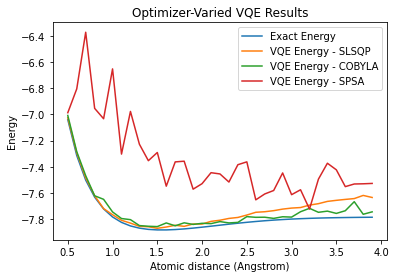

In [30]:
plot_potential_well(opt_labels = ["SLSQP","COBYLA","SPSA"], distances = ds, vqe_energies = vqe_energies, 
                    exact_energies = exact_energies)

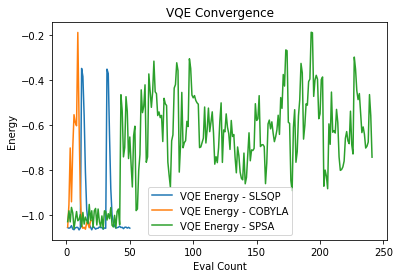

In [31]:
plot_iterations(opt_labels = ["SLSQP","COBYLA","SPSA"], converge_itrs = converge_itrs, converge_vals = converge_vals)